In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [2]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
import jax.numpy as jnp
import xgboost as xgb
import jax
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import anndata

## define function to get vector from DMSO to pert for each pert to each cell line.  GPU-ing this did make a difference

In [3]:
def get_pert_vectors(adata):
    # Extract metadata and group labels
    meta_df = adata.obs[['cell_name', 'drugname_drugconc']].copy()
    meta_df['group'] = meta_df['cell_name'].astype(str) + '|' + meta_df['drugname_drugconc'].astype(str)
    # Map groups to integer indices
    group_idx, unique_groups = pd.factorize(meta_df['group'])
    # Then run your code
    # Extract metadata and group labels
    meta_df = adata.obs[['cell_name', 'drugname_drugconc']].copy()
    meta_df['group'] = meta_df['cell_name'].astype(str) + '|' + meta_df['drugname_drugconc'].astype(str)
    adata.obs['group'] = adata.obs['cell_name'].astype(str) + '|' + adata.obs['drugname_drugconc'].astype(str)
    print('here')
    # Map groups to integer indices
    group_idx, unique_groups = pd.factorize(meta_df['group'])
    # X_jax: (n_cells, n_dims)
    # group_idx: int array of length n_cells (e.g., from pd.factorize)
    X_jax = jnp.array(adata.X.astype('float32'))
    print('here')
    group_idx = jnp.array(group_idx)
    n_groups = len(unique_groups)
    sums = jax.ops.segment_sum(X_jax, group_idx, n_groups)
    counts = jax.ops.segment_sum(jnp.ones((X_jax.shape[0], 1)), group_idx, n_groups)
    centroids = sums / counts
    # Back to Pandas to identify DMSO indices
    group_labels = pd.Series(unique_groups)
    cell_types = group_labels.str.split('|').str[0]
    perts = group_labels.str.split('|').str[1]
    # Find the index of each DMSO centroid by cell_type
    dmso_idx = (perts == "[('DMSO_TF', 0.0, 'uM')]")
    # Convert boolean mask to indices for JAX
    dmso_indices = np.where(dmso_idx.values)[0]  # Convert pandas boolean to JAX indices
    dmso_centroids = centroids[dmso_indices]
    # Match non-DMSO centroids to their corresponding DMSO by cell_type
    pert_indices = np.where(~dmso_idx.values)[0]  # Also convert this to JAX indices
    pert_cell_types = cell_types[~dmso_idx].values
    # Build a lookup: cell_type → index in dmso_centroids
    dmso_cell_types = cell_types[dmso_idx].values
    dmso_cell_type_to_idx = dict(zip(dmso_cell_types, dmso_indices))
    # Get DMSO centroid for each perturbation group
    dmso_for_pert = np.stack([
        centroids[dmso_cell_type_to_idx[ct]] for ct in pert_cell_types
    ])
    # Compute perturbation vectors
    pert_vectors = centroids[pert_indices] - dmso_for_pert
    reference_df = pd.DataFrame({
    'variable': cell_types,
    'drug': perts,
    'order': range(len(cell_types))
    })
    return pert_vectors, reference_df

## My code is setup for a previous version of the objects that had the embeddings in .X

additionally, the objects are big enough that if the have both embeddings and values, it breaks.  I subset, but that doesn;t make much of a difference, because I ultimatley calculate centroids

In [4]:
adata_real = sc.read_h5ad("../../../../adata_real.h5ad", backed = True)
adata_real = anndata.AnnData(X = adata_real.obsm['X_vci_1.5.2_4'], obs = adata_real.obs)
sc.pp.sample(adata_real, 0.25)

In [ ]:
adata_real.obs

NameError: name 'adata_real' is not defined

In [ ]:
real_vectors, ref = get_pert_vectors(adata_real)

NameError: name 'adata_real' is not defined

In [ ]:
del adata_real

NameError: name 'adata_real' is not defined

## import the survival data and align with the pert-vectors

In [ ]:
survival = pd.read_csv('/large_storage/ctc/public/tahoe/survival_data/log2fc_survivals_averaged_across_plate.csv')
survival = survival.melt(id_vars= ['drug'])
survival['drug'] = survival['drug'].apply(
    lambda x: f"[('{x.split('_')[0]}', {x.split('_')[1]}, 'uM')]"
)
# Create combined reference

ref = ref[ref['drug'] != "[('DMSO_TF', 0.0, 'uM')]"]
# Merge to get the order, then sort
survival = survival.merge(ref, on=['variable', 'drug'], how='right')
survival = survival.sort_values('order').drop('order', axis=1)

annoyingly, a couple of perts are missing from the survival data

In [ ]:
pert_vectors = np.asarray(real_vectors)
# Get the mask from the original survival dataframe
valid_mask = ~survival['value'].isna()
x = pert_vectors[valid_mask.values, :]
y = survival['value'][valid_mask].values


In [ ]:
ref['variable'].value_counts()

variable
C32          735
HOP62        735
Hs 766T      734
PANC-1       734
HepG2/C3A    734
Name: count, dtype: int64

In [ ]:
ref['variable'].value_counts()

variable
C32          735
HOP62        735
Hs 766T      734
PANC-1       734
HepG2/C3A    734
Name: count, dtype: int64

train a SVM to predict the survival from the pert-vectors.  I pick 4 random drugs to mask, and I mask all of their doses.  If you are trying to reporduce this, you will need to copy the names as outputted

In [ ]:
import random
drugs = survival['drug'].str.split(',').str[0].unique()
drugs = [x[5:] for x in drugs]
drugs = random.sample(list(drugs), 4)
print(drugs)
drugs_regex = '|'.join(drugs)


["xadustat'", "limetinib dimesylate'", "citabine'", "rosemide'"]


In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
valid_mask = ~survival['value'].isna()
# Apply the same mask to both
x = pert_vectors[valid_mask.values, :]
y = survival['value'][valid_mask].values
train_mask =  ~(survival['drug'].str.contains(drugs_regex)) & ~(survival['value'].isna())
X_train = pert_vectors[train_mask, :]
y_train = survival['value'][train_mask].values
test_mask = (survival['drug'].str.contains(drugs_regex)) & ~(survival['value'].isna())
X_test = pert_vectors[test_mask, :]
y_test = survival['value'][test_mask].values
# Scale the features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Scale the features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit SVM
svm = SVR(kernel='rbf')  # or 'rbf', 'poly', etc.
svm.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svm.predict(X_test_scaled)

# Regression metrics
print("SVR Regression Metrics:")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.4f}")
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import pearsonr

r, p = pearsonr(y_test, y_pred)

print(f"Pearson r  = {r:.4f}")
print(f"Pearson r² = {r**2:.4f}")
print(f"p-value    = {p:.4e}")


SVR Regression Metrics:
R² Score: 0.5900
Mean Squared Error: 0.0130
Root Mean Squared Error: 0.1138
Mean Absolute Error: 0.0893
Pearson r  = 0.8250
Pearson r² = 0.6806
p-value    = 5.3030e-16


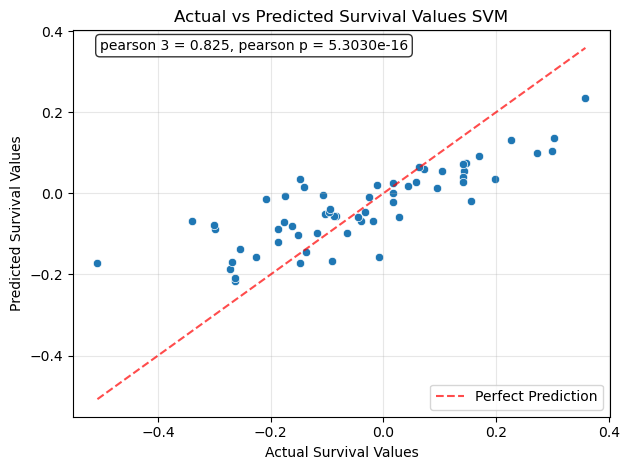

In [ ]:
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Survival Values')
plt.ylabel('Predicted Survival Values')
plt.title('Actual vs Predicted Survival Values SVM')

# Add a diagonal line for perfect predictions
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Perfect Prediction')
plt.legend()

# Optional: Add R² score as text on the plot
r2 = r2_score(y_test, y_pred)
plt.text(0.05, 0.95, f'pearson 3 = {r:.3f}, pearson p = {p:.4e}', transform=plt.gca().transAxes, 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('model_real_embeddings_survival_fit.pdf')

In [ ]:
xg = xgb.XGBRegressor()
xg.fit(X_train_scaled, y_train)
xg_pred = xg.predict(X_test_scaled)
print("XgB Regression Metrics:")
print(f"R² Score: {r2_score(y_test, xg_pred):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, xg_pred):.4f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, xg_pred)):.4f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, xg_pred):.4f}")

XgB Regression Metrics:
R² Score: 0.4492
Mean Squared Error: 0.0174
Root Mean Squared Error: 0.1319
Mean Absolute Error: 0.1013


In [ ]:
adata_pred = sc.read_h5ad('/large_storage/ctc/userspace/alishba.imran/state-sets/kras_split1_vci_copy/eval_step=200000.ckpt/adata_pred.h5ad')
adata_pred = sc.read_h5ad("../adata_real.h5ad", backed = True)
adata_pred = anndata.AnnData(X = adata_pred.obsm['X_vci_1.5.2_4'], obs = adata_pred.obs)

sc.pp.sample(adata_pred, 0.25)

In [ ]:
pert_indices_pred, ref_pred = get_pert_vectors(adata_pred)

here
here


In [ ]:
del adata_pred

In [ ]:

survival = pd.read_csv('/large_storage/ctc/public/tahoe/survival_data/log2fc_survivals_averaged_across_plate.csv')
survival = survival.melt(id_vars= ['drug'])
survival['drug'] = survival['drug'].apply(
    lambda x: f"[('{x.split('_')[0]}', {x.split('_')[1]}, 'uM')]"
)

ref_pred = ref_pred[ref_pred['drug'] != "[('DMSO_TF', 0.0, 'uM')]"]
# Merge to get the order, then sort
survival = survival.merge(ref_pred, on=['variable', 'drug'], how='right')
survival = survival.sort_values('order').drop('order', axis=1)

In [ ]:
train_mask.value_counts()

True     3596
False      76
Name: count, dtype: int64

In [ ]:
valid_mask = ~survival['value'].isna()

# Apply the same mask to both
x = pert_indices_pred[valid_mask.values, :]
y = survival['value'][valid_mask].values
train_mask =  ~(survival['drug'].str.contains(drugs_regex)) & ~(survival['value'].isna())
X_train = pert_indices_pred[train_mask.values, :]
y_train = survival['value'][train_mask].values
test_mask = (survival['drug'].str.contains(drugs_regex)) & ~(survival['value'].isna())
X_test = pert_indices_pred[test_mask.values, :]
y_test = survival['value'][test_mask].values
# Scale the features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit SVM
#svm = SVR(kernel='linear')  # or 'rbf', 'poly', etc.
#svm.fit(X_train_scaled, y_train)

# Make predictions
y_pred = xg.predict(scaler.fit_transform(X_test))

R² Score: 0.4839


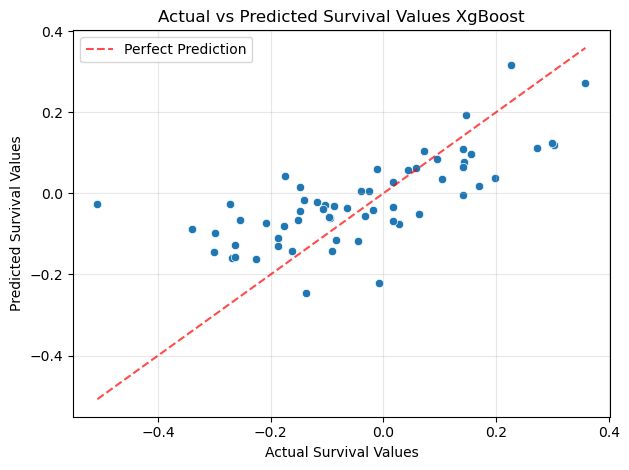

In [ ]:
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Survival Values')
plt.ylabel('Predicted Survival Values')
plt.title('Actual vs Predicted Survival Values XgBoost')

# Add a diagonal line for perfect predictions
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Perfect Prediction')
plt.legend()


plt.grid(True, alpha=0.3)
plt.tight_layout()

In [ ]:
y_pred = svm.predict(scaler.fit_transform(X_test))

In [ ]:
from scipy.stats import pearsonr
r, p = pearsonr(y_test, y_pred)

print(f"Pearson r  = {r:.4f}")
print(f"Pearson r² = {r**2:.4f}")
print(f"p-value    = {p:.4e}")

Pearson r  = 0.7976
Pearson r² = 0.6362
p-value    = 2.3946e-14


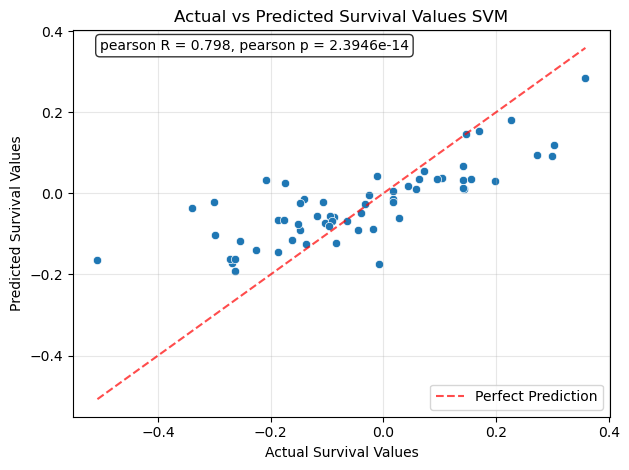

In [ ]:

sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Survival Values')
plt.ylabel('Predicted Survival Values')
plt.title('Actual vs Predicted Survival Values SVM')

# Add a diagonal line for perfect predictions
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Perfect Prediction')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
r2 = r2_score(y_test, y_pred)
plt.text(0.05, 0.95, f'pearson R = {r:.3f}, pearson p = {p:.4e}', transform=plt.gca().transAxes, 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.savefig('survival_on_new_predictions.pdf')